In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import data_utils
import train_utils
import models

%reload_ext autoreload
%autoreload 2

In [6]:
train = data_utils.COAD_dataset(data_utils.COAD_TRAIN)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True , pin_memory=True)

valid = data_utils.COAD_dataset(data_utils.COAD_VALID)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=False , pin_memory=True)

In [110]:
input_size = 512
hidden_size = 512
output_size = 1
attn = models.Attention(input_size, hidden_size, output_size)

n_conv_layers = 2
n_fc_layers = 2
kernel_size = [4,3]
n_conv_filters = [36,48]
hidden_size = [512,512]
dropout=0.5
net = models.ConvNet(n_conv_layers, n_fc_layers, kernel_size, n_conv_filters, hidden_size, dropout=dropout)


state_dict = torch.load('convnet_attention_embed.pt')
net.load_state_dict(state_dict)
net = net.cuda()

state_dict = torch.load('attention_pool_embed.pt')
attn.load_state_dict(state_dict)
attn = attn.cuda()
pool_fn = models.pool(attn)


In [36]:
def compute_attention(valid_loader, net, attn):
    net.eval()
    attention = []
    labels = []
    with torch.no_grad():
        for slide,label in valid_loader:
            slide.squeeze_()
            slide, label = slide.cuda(), label.cuda()
            output = net(slide)
            a = attn(output)
            attention.append(a.detach().cpu().numpy())
            labels.append(label.detach().cpu().numpy())
    return attention,np.concatenate(labels)

In [37]:
attention, labels = compute_attention(valid_loader, net, attn)

In [43]:
atn_cancer = []
cell_label_cancer = []
for idx,(avec,cell_labels) in enumerate(zip(attention,valid.cell_labels)):
    if labels[idx]==1:
        atn_cancer.extend(np.concatenate(avec))
        cell_label_cancer.extend(cell_labels)

In [44]:
import pandas as pd

In [45]:
results = pd.DataFrame({'attention':atn_cancer,'cell_label':cell_label_cancer})

In [46]:
results.head()

,attention,cell_label
0,0.015029,epi
1,0.011585,epi
2,0.019538,epi
3,0.007091,epi
4,0.003083,epi


In [55]:
epi_weight = results.groupby('cell_label').mean()['attention'].values[0]
total_weight = np.sum(results.groupby('cell_label').mean()['attention'].values)
print(epi_weight/total_weight)

0.6754605760746788


In [52]:
atn_normal = []
cell_label_normal = []
for idx,(avec,cell_labels) in enumerate(zip(attention,valid.cell_labels)):
    if labels[idx]==0:
        atn_normal.extend(np.concatenate(avec))
        cell_label_normal.extend(cell_labels)

In [53]:
results_n = pd.DataFrame({'attention':atn_normal,'cell_label':cell_label_normal})

In [58]:
results_n.groupby('cell_label').mean().values[-1]/np.sum(results_n.groupby('cell_label').mean().values)

array([0.63912081])

In [148]:
image = np.zeros([500,500,3])
locs = valid.cell_locs[35]
slide=valid.data[35]
label = torch.tensor(valid.labels[35])

slide, label = slide.view(-1,3,27,27).cuda(), label.cuda()
output = net(slide)
a = attn(output)


In [134]:
import pandas as pd
pd.DataFrame({'attn':a.detach().squeeze().cpu().numpy(),'label':valid.cell_labels[35]}).groupby('label').mean()

,attn
label,
epi,0.003561
fibro,0.000915
inf,0.000293
other,0.002563


(409, 3, 27, 27)

In [149]:
for i,tile in enumerate(slide.cpu()):    
    image[locs[i][1]-13:locs[i][1]+14,locs[i][0]-13:locs[i][0]+14] = tile.numpy().reshape(27,27,3)#*255.0*((a_np[i]-a_min)/(a_max - a_min))

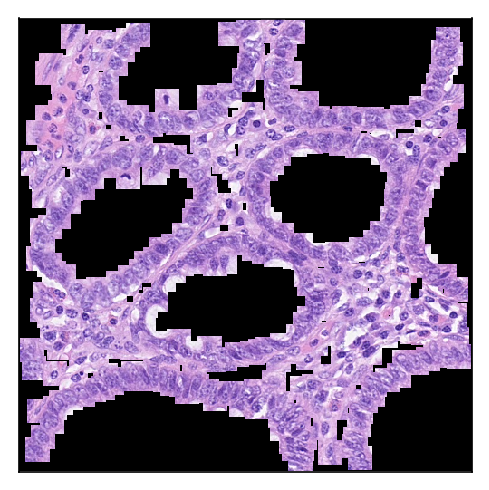

In [150]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
plt.imshow(image)
fig.set_dpi(150)
plt.xticks([])
plt.yticks([])
plt.savefig('Example_Slide_unweighted.png')

In [141]:
a_prime = (a - a.min())/(a.max()-a.min())

In [144]:
a_prime = a_prime.detach().cpu().numpy()

In [152]:
image = np.zeros([500,500,3])
for i,tile in enumerate(slide.cpu()):    
    image[locs[i][1]-13:locs[i][1]+14,locs[i][0]-13:locs[i][0]+14] = tile.numpy().reshape(27,27,3)*a_prime[i]#*255.0*((a_np[i]-a_min)/(a_max - a_min))

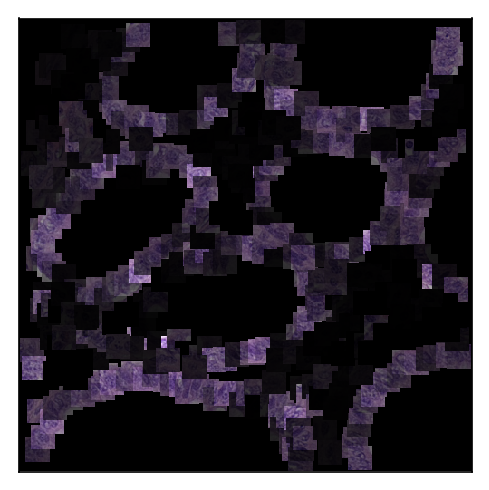

In [153]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
plt.imshow(image)
fig.set_dpi(150)
plt.xticks([])
plt.yticks([])
plt.savefig('Example_Slide_attn_weighted.png')